# Cell counting

We will examine the use of U-Nets to perform cell counting, a crucial task to determine the number of cells in cell cultures before and after treatment.

## Cell nuclei images

We used image set BBBC039v1 Caicedo et al. 2018, available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].

This data set has a total of 200 fields of view of nuclei captured with fluorescence microscopy using the Hoechst stain. The collection has around 23,000 single nuclei manually annotated to establish a ground truth collection for segmentation evaluation.

The images are stored as TIFF files with 520x696 pixels at 16 bits. Ground truth annotations are stored as PNG files encoding masks of independent nuclei.

https://data.broadinstitute.org/bbbc/BBBC039/

In [1]:
import os
import deeptrack as dt

dt.config.disable_image_wrapper()

raw_path = os.path.join("nuclei", "images")
label_path = os.path.join("nuclei", "masks")

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

paths = dt.sources.Source(raw=raw_paths, label=label_paths)
train_paths, test_paths = dt.sources.random_split(paths, [0.7, 0.3])

train_sources = train_paths.product(
    flip_ud=[True, False],
    flip_lr=[True, False],
    crop=[0, 1, 2],
    should_crop=[True],
)

test_sources = test_paths.constants(
    flip_ud=False,
    flip_lr=False,
    should_crop=False,
)

sources = dt.sources.Sources(train_sources, test_sources)

print(f"{len(train_sources)} training images")
print(f"{len(test_sources)} test images")

2024-01-27 17:30:02.093767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1680 training images
60 test images


We write a pipeline to load the images and the corresponding masks and display a few examples, with the corresponding histograms. 

/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


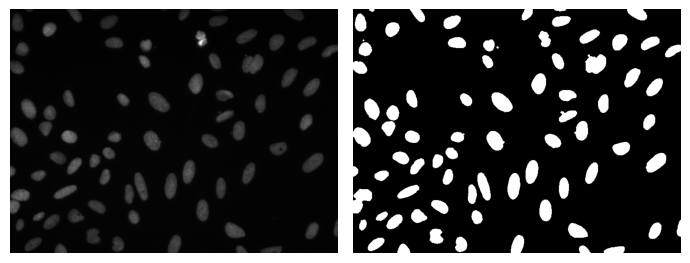

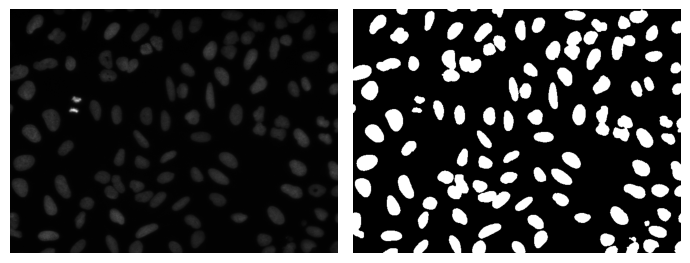

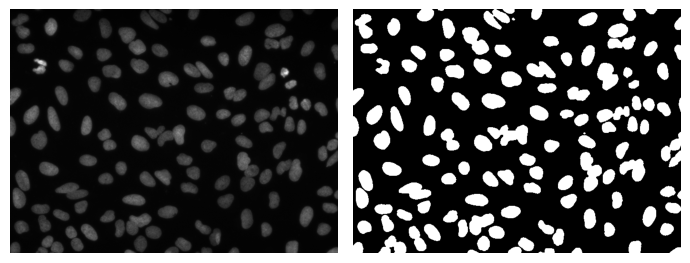

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader


def binary_mask(threshold=0):
    def inner(gt_seg_image):
        out = gt_seg_image.copy()
        out = np.where(out > threshold, 1, 0)
        return out

    return inner


im_pipeline = dt.LoadImage(sources.raw.path) >> dt.AsType("float") >> dt.Divide(3000)

lab_pipeline = (
    dt.LoadImage(sources.label.path)[:, :, 0:1]
    >> dt.AsType("float")
    >> binary_mask(threshold=0)
)

pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.ConditionalSetFeature(
        on_true=dt.Crop(crop=(128, 128, None)),
        on_false=dt.Crop(crop=(512, 688, None), corner=(0, 0)),
        condition=sources.should_crop,
    )
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

train_dataset = dt.pytorch.Dataset(pipeline, train_sources)
test_dataset = dt.pytorch.Dataset(pipeline, test_sources)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for i in range(3):
    image, mask = test_dataset[i]
    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

To count the number of cells, we will use the number of connected components of the segmentaion mask, i.e. groups of adjacents pixels with the same value. 

For this, we can first _label_ the mask by assigning a different integer label to each component. We will verify it on the images we just displayed.

In [3]:
from skimage.morphology import label


def count_connected_components(mask):
    labeled_mask = label(mask)
    return labeled_mask.max()


for i in range(3):
    _, mask = test_dataset[i]
    print("Number of cells = " + str(count_connected_components(mask)))

Number of cells = 76
Number of cells = 107
Number of cells = 117


## UNet

We will use a UNet to segment the cells.

In [4]:
import deeplay as dl

unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64, 128],
    out_channels=1,
)
print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

We use the binary crossentropy loss

In [5]:
import torchmetrics as tm
from torch.nn import BCEWithLogitsLoss

unet_regressor = dl.Regressor(
    model=unet,
    loss=BCEWithLogitsLoss(),
    optimizer=dl.Adam(),
).create()

We train the network for 30 epochs.

In [6]:
unet_trainer = dl.Trainer(max_epochs=30, accelerator="auto")

unet_trainer.fit(unet_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name   

Training: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


We'll apply it to all the images in the test set and calculate true and predicted number of cells.

In [7]:
images, labels, preds = [], [], []

for im, lab in test_loader:
    images.append(im)
    labels.append(lab)
    pr = unet_regressor(im).detach()
    pr = torch.nn.functional.sigmoid(pr)
    preds.append(pr)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)
true_count = [count_connected_components(l.squeeze()) for l in labels]
pred_count = [count_connected_components(p.squeeze() > 0.5) for p in preds]

We calculate MAE and MPE and display the results in a scatterplot.

MAE: 3.23
MPE: 0.04


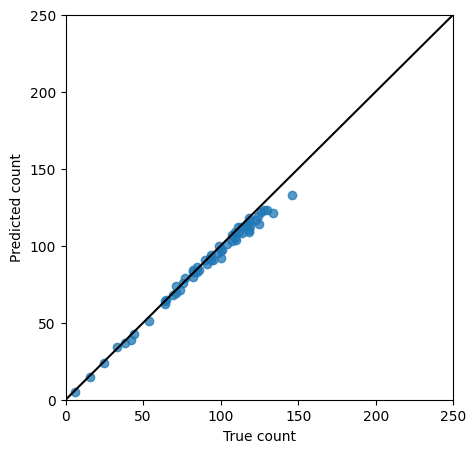

In [8]:
pred_count = np.array(pred_count)
true_count = np.array(true_count)
mae = abs(pred_count - true_count).mean()
nonzeros = true_count > 0
mpe = (abs(pred_count[nonzeros] - true_count[nonzeros]) / (true_count[nonzeros])).mean()
print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}")
plt.figure(figsize=(5, 5))
plt.scatter(true_count, pred_count, alpha=0.75)
plt.axline([0, 0], [1, 1], color="black")
plt.xlabel("True count")
plt.ylabel("Predicted count")
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()

## Improving the predictions

There is a clear bias in the predicted counts. As the true number of cells increases, cells are closer to each other and segmentations overlap, joining connected regions. To prevent this issue, we will now represent the cells as small disks in the segmentation mask.

In [ ]:
from skimage.morphology import disk

segmentation_disk = disk(3)
segmentation_disk = segmentation_disk[..., None]
label_pipeline = non_overlapping_cells >> dt.SampleToMasks(
    lambda: lambda x: segmentation_disk,
    output_region=optics.output_region,
    merge_method="or",
)

image_and_gt_pipeline = (
    (image_pipeline & label_pipeline)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

Let's train the UNet again...

...and check the predictions.

In [ ]:
i = 0

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(images[i].squeeze(), cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(labels[i].squeeze(), cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(preds[i].squeeze(), cmap="gray")
plt.axis("off")
plt.show()

Using small disks as segmentation maps doesn't solve the problem completely.

Instead of using a binary mask, we can represent the cells as two-dimensional Gaussian distributions. Since the sum of each Gaussian distribution is constant for all cells, we can then count the cells by summing the values in the prediction. This provides a more robust solution to the occurrence of overlapping cells.

We also modify the UNet final activation, setting it back to the default (ReLU)...

In [ ]:
from torch.nn import ReLU

unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64, 128],
    out_channels=1,
    out_activation=ReLU(),
)

... and the loss function.

In [ ]:
import torch.nn as nn


class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predictions, targets):
        count_loss = torch.mean(
            torch.abs(
                torch.mean(predictions, dim=(1, 2, 3))
                - torch.mean(targets, dim=(1, 2, 3))
            )
        )
        mse_loss = torch.mean((predictions - targets) ** 2)
        return mse_loss + count_loss


from torch.nn import MSELoss

unet_regressor = dl.Regressor(
    model=unet,
    loss=CustomLoss(),
    optimizer=dl.Adam(),
).create()

We train again...

In [ ]:
train_dataset = dt.pytorch.Dataset(image_and_gt_pipeline, length=960, replace=False)
train_loader = DataLoader(train_dataset, batch_size=32)
unet_trainer = dl.Trainer(max_epochs=100, accelerator="auto")

unet_trainer.fit(unet_regressor, train_loader)

... and check the predictions.

In [ ]:
for i in range(3):
    raw_image, mask = image_and_gt_pipeline.update()()

    raw_image = raw_image.unsqueeze(0)

    pred = unet_regressor(raw_image).detach() / 100

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(raw_image.squeeze(), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pred.squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

In [ ]:
images, labels, preds = [], [], []

for im, lab in test_loader:
    images.append(im)
    labels.append(lab)
    pr = unet_regressor(im).detach()
    # pr = torch.nn.functional.sigmoid(pr)
    preds.append(pr)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)
true_count = [count_connected_components(l.squeeze()) for l in labels]
pred_count = [torch.sum(p.squeeze() / 100) for p in preds]

pred_count = np.array(pred_count)
true_count = np.array(true_count)
mae = abs(pred_count - true_count).mean()
nonzeros = true_count > 0
mpe = (abs(pred_count[nonzeros] - true_count[nonzeros]) / (true_count[nonzeros])).mean()
print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}")
plt.figure(figsize=(5, 5))
plt.scatter(true_count, pred_count, alpha=0.75)
plt.axline([0, 0], [1, 1], color="black")
plt.xlabel("True count")
plt.ylabel("Predicted count")
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()